In [1]:
import sys
from torchvision import transforms
import numpy as np
from vocabulary import Vocabulary
import matplotlib.pyplot as plt
%matplotlib inline

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

### Part 1. Load two vocabulary files

In [2]:
vocab_threshold = None
vocab_large = './vocab/vocab_large.pkl'
vocab_small = './vocab/vocab_small.pkl'
vocab_from_file = True

vocab_large = Vocabulary(vocab_threshold = None, 
                         vocab_file = vocab_large, 
                         vocab_from_file = True)

vocab_small = Vocabulary(vocab_threshold = None, 
                         vocab_file = vocab_small, 
                         vocab_from_file = True)

Vocabulary successfully loaded form file!
Vocabulary successfully loaded form file!


### Part 2. Load pretrained network

In [3]:
import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file_large = 'encoder-large.pkl'
decoder_file_large = 'decoder-large.pkl'

encoder_file_small = 'encoder-small.pkl'
decoder_file_small = 'decoder-small.pkl'

# Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size_large = len(vocab_large)
vocab_size_small = len(vocab_small)

# Initialize the encoder and decoder, and set each to inference mode.
encoder_large = EncoderCNN(embed_size)
encoder_large.eval()
decoder_large = DecoderRNN(embed_size, hidden_size, vocab_size_large)
decoder_large.eval()

encoder_small = EncoderCNN(embed_size)
encoder_small.eval()
decoder_small = DecoderRNN(embed_size, hidden_size, vocab_size_small)
decoder_small.eval()

# Load the trained weights.
encoder_large.load_state_dict(torch.load(os.path.join('./models', encoder_file_large)))
decoder_large.load_state_dict(torch.load(os.path.join('./models', decoder_file_large)))

encoder_small.load_state_dict(torch.load(os.path.join('./models', encoder_file_small)))
decoder_small.load_state_dict(torch.load(os.path.join('./models', decoder_file_small)))

# Move models to GPU if CUDA is available.
encoder_large.to(device)
decoder_large.to(device)
encoder_small.to(device)
decoder_small.to(device)

DecoderRNN(
  (word_embeddings): Embedding(4640, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=4640, bias=True)
)

### Part 3. Functions of image preprocessor, sentence translator and predictor

In [4]:
from PIL import Image
def imageProcess(img_path):    
    PIL_image = Image.open(img_path).convert('RGB')
    orig_image = np.array(PIL_image)
    image = transform_test(PIL_image)
    image = image.unsqueeze(0)
    return orig_image, image

In [5]:
# Generate sentance from vector by given vocab
def clean_sentence(output, vocab): 
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = vocab.idx2word[idx]
        sentence = sentence + word + ' '        
    return sentence

In [6]:
def get_prediction_large(image):
    image = image.to(device)
    features = encoder_large(image).unsqueeze(1)
    output = decoder_large.sample(features)    
    sentence = clean_sentence(output, vocab_large)
    print("Large Vocab: ", sentence)
    
def get_prediction_small(image):
    image = image.to(device)
    features = encoder_small(image).unsqueeze(1)
    #print(features)
    output = decoder_small.sample(features)    
    sentence = clean_sentence(output, vocab_small)
    print("Small Vocab: ", sentence)

In [7]:
def prediction(orig_image, image):
    # show original image
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    # Caption prediction of two vocab
    get_prediction_large(image)
    get_prediction_small(image)

### Part 4. Demo! Change the image path to your own, check how our function works.

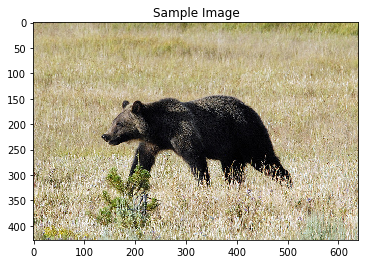

Large Vocab:  a bear walking in the grass near a tree . 
Small Vocab:  a bear is walking in an area with a lot of foliage . 


In [8]:
# Demo image is from the coco test 2015 dataset on our server.
img = '/datasets/COCO-2015/test2015/COCO_test2015_000000193886.jpg'
orig_image, image = imageProcess(img)
prediction(orig_image, image)